In [1]:
from photutils.datasets import load_simulated_hst_star_image
import numpy as np
import plotly.express as px
from astropy.visualization import simple_norm
from photutils.datasets import make_noise_image



In [2]:
import re
import dash
from dash import dcc, html, Input, Output, State, no_update
import plotly.graph_objects as go
import numpy as np
import pandas as pd


def _parse_latest_rect_from_relayout(relayout):
    if not relayout:
        return None

    shapes = relayout.get("shapes")
    if isinstance(shapes, list) and shapes:
        s = shapes[-1]
        if isinstance(s, dict) and s.get("type") == "rect":
            return float(s["x0"]), float(s["x1"]), float(s["y0"]), float(s["y1"])

    return None


class StarBackgroundApp:

    def __init__(self, image_data, scale="log", q_low=0.91, q_high=0.99):

        self.image = np.asarray(image_data)
        self.ny, self.nx = self.image.shape

        self.star_regions = []
        self.background_pixels = []

        # -------- Display scaling --------
        if scale == "log":
            img = self.image.astype(float).copy()
            m = img.min()
            if m <= 0:
                img = img - m + 1e-6
            vmin = np.quantile(img, q_low)
            vmax = np.quantile(img, q_high)
            img = np.clip(img, vmin, vmax)
            img = np.log10(img)
        else:
            img = self.image

        self.fig = go.Figure()

        # Trace 0: Heatmap
        self.fig.add_trace(go.Heatmap(
            z=img,
            colorscale="viridis",
            showscale=False,
            hoverinfo="skip"
        ))

        # Trace 1: Stars
        self.fig.add_trace(go.Scatter(
            x=[], y=[],
            mode="markers",
            marker=dict(size=10, color="black", symbol="square"),
            name="Stars",
            hoverinfo="skip"
        ))

        self.fig.update_layout(
            dragmode="drawrect",
            uirevision="static",
            shapes=[],
            newshape=dict(
                fillcolor="rgba(0,0,0,0)",
                line=dict(color="white", width=2)
            )
        )

        self.fig.update_yaxes(scaleanchor="x", scaleratio=1)

    # ---------------------------------------------------------
    # STAR rectangle
    # ---------------------------------------------------------
    def add_star_rectangle(self, x0, x1, y0, y1, tol=3):

        xmin = int(max(0, np.floor(min(x0, x1))))
        xmax = int(min(self.nx, np.ceil(max(x0, x1))))
        ymin = int(max(0, np.floor(min(y0, y1))))
        ymax = int(min(self.ny, np.ceil(max(y0, y1))))

        if xmax - xmin < 2 or ymax - ymin < 2:
            return

        window = self.image[ymin:ymax, xmin:xmax]
        yy, xx = np.mgrid[ymin:ymax, xmin:xmax]

        total = float(window.sum())
        if total <= 0:
            return

        x_c = float((xx * window).sum() / total)
        y_c = float((yy * window).sum() / total)

        # toggle
        for r in self.star_regions:
            dx = r["x"] - x_c
            dy = r["y"] - y_c
            if dx*dx + dy*dy < tol*tol:
                self.star_regions.remove(r)
                return

        self.star_regions.append({
            "x": x_c,
            "y": y_c,
            "flux": total
        })

    # ---------------------------------------------------------
    # BACKGROUND rectangle (no render)
    # ---------------------------------------------------------
    def add_background_rectangle(self, x0, x1, y0, y1):

        xmin = int(max(0, np.floor(min(x0, x1))))
        xmax = int(min(self.nx, np.ceil(max(x0, x1))))
        ymin = int(max(0, np.floor(min(y0, y1))))
        ymax = int(min(self.ny, np.ceil(max(y0, y1))))

        yy, xx = np.mgrid[ymin:ymax, xmin:xmax]

        self.background_pixels.extend([
            {
                "x": int(x),
                "y": int(y),
                "value": float(self.image[int(y), int(x)])
            }
            for x, y in zip(xx.ravel(), yy.ravel())
        ])

    # ---------------------------------------------------------
    def update_figure(self):

        self.fig.data[1].x = [r["x"] for r in self.star_regions]
        self.fig.data[1].y = [r["y"] for r in self.star_regions]

        return self.fig

    # ---------------------------------------------------------
    def save_csv(self):

        pd.DataFrame(self.star_regions).to_csv(
            "star_centroids.csv", index=False
        )

        pd.DataFrame(self.background_pixels).to_csv(
            "background_pixels.csv", index=False
        )

        return f"{len(self.star_regions)} stars | {len(self.background_pixels)} background pixels saved"





In [3]:

# -------------------------------------------------
# Imagen
# -------------------------------------------------
hdu = load_simulated_hst_star_image()
data = hdu.data
data += make_noise_image(data.shape, distribution='gaussian',
                         mean=10.0, stddev=5.0, seed=0)
# ================= INIT =================

logic = StarBackgroundApp(data)

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(
        id="graph",
        figure=logic.update_figure(),
        config={
            "scrollZoom": True,
            "modeBarButtonsToAdd": ["drawrect", "eraseshape"],
            "displaylogo": False
        },
        style={"height": "85vh"}
    ),
    html.Button("Mode: Star", id="star-btn"),
    html.Button("Mode: Background", id="bg-btn"),
    html.Button("Save CSV", id="save-btn"),
    html.Pre(id="output"),
    dcc.Store(id="mode", data="star")
])


@app.callback(
    Output("graph", "figure"),
    Output("mode", "data"),
    Output("output", "children"),
    Input("star-btn", "n_clicks"),
    Input("bg-btn", "n_clicks"),
    Input("save-btn", "n_clicks"),
    Input("graph", "relayoutData"),
    State("mode", "data"),
    prevent_initial_call=True
)
def controller(n_star, n_bg, n_save, relayout, mode):

    trigger = dash.callback_context.triggered[0]["prop_id"]

    if "star-btn" in trigger:
        logic.fig.update_layout(newshape=dict(
            fillcolor="rgba(0,0,0,0)",
            line=dict(color="white", width=2)
        ))
        return logic.update_figure(), "star", "Mode = star"

    if "bg-btn" in trigger:
        logic.fig.update_layout(newshape=dict(
            fillcolor="rgba(0,0,0,0)",
            line=dict(color="red", width=2)
        ))
        return logic.update_figure(), "background", "Mode = background"

    if "save-btn" in trigger:
        return logic.update_figure(), mode, logic.save_csv()

    rect = _parse_latest_rect_from_relayout(relayout)
    if rect:
        x0, x1, y0, y1 = rect

        if mode == "star":
            logic.add_star_rectangle(x0, x1, y0, y1)
        else:
            logic.add_background_rectangle(x0, x1, y0, y1)

        logic.fig.update_layout(shapes=[])

        return logic.update_figure(), mode, ""

    return no_update, mode, ""


if __name__ == "__main__":
    app.run(debug=True)

In [8]:
df_background = pd.read_csv("background_pixels.csv")

In [9]:
sources = pd.read_csv("star_centroids.csv")

In [6]:
from astropy.table import Table
size = 25
hsize = (size - 1) / 2
x = sources["x"]
y = sources["y"]
mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
        (y > hsize) & (y < (data.shape[0] -1 - hsize)))

#x = peaks_tbl["x_peak"]
#y = peaks_tbl["y_peak"]
stars_tbl = Table()
stars_tbl['x'] = x[mask]
stars_tbl['y'] = y[mask]

In [15]:
data_norm  = data - np.median(df_background["value"].values)

In [16]:
from astropy.nddata import NDData
nddata = NDData(data=data_norm)

In [17]:
from photutils.psf import extract_stars
stars = extract_stars(nddata, stars_tbl, size=25)

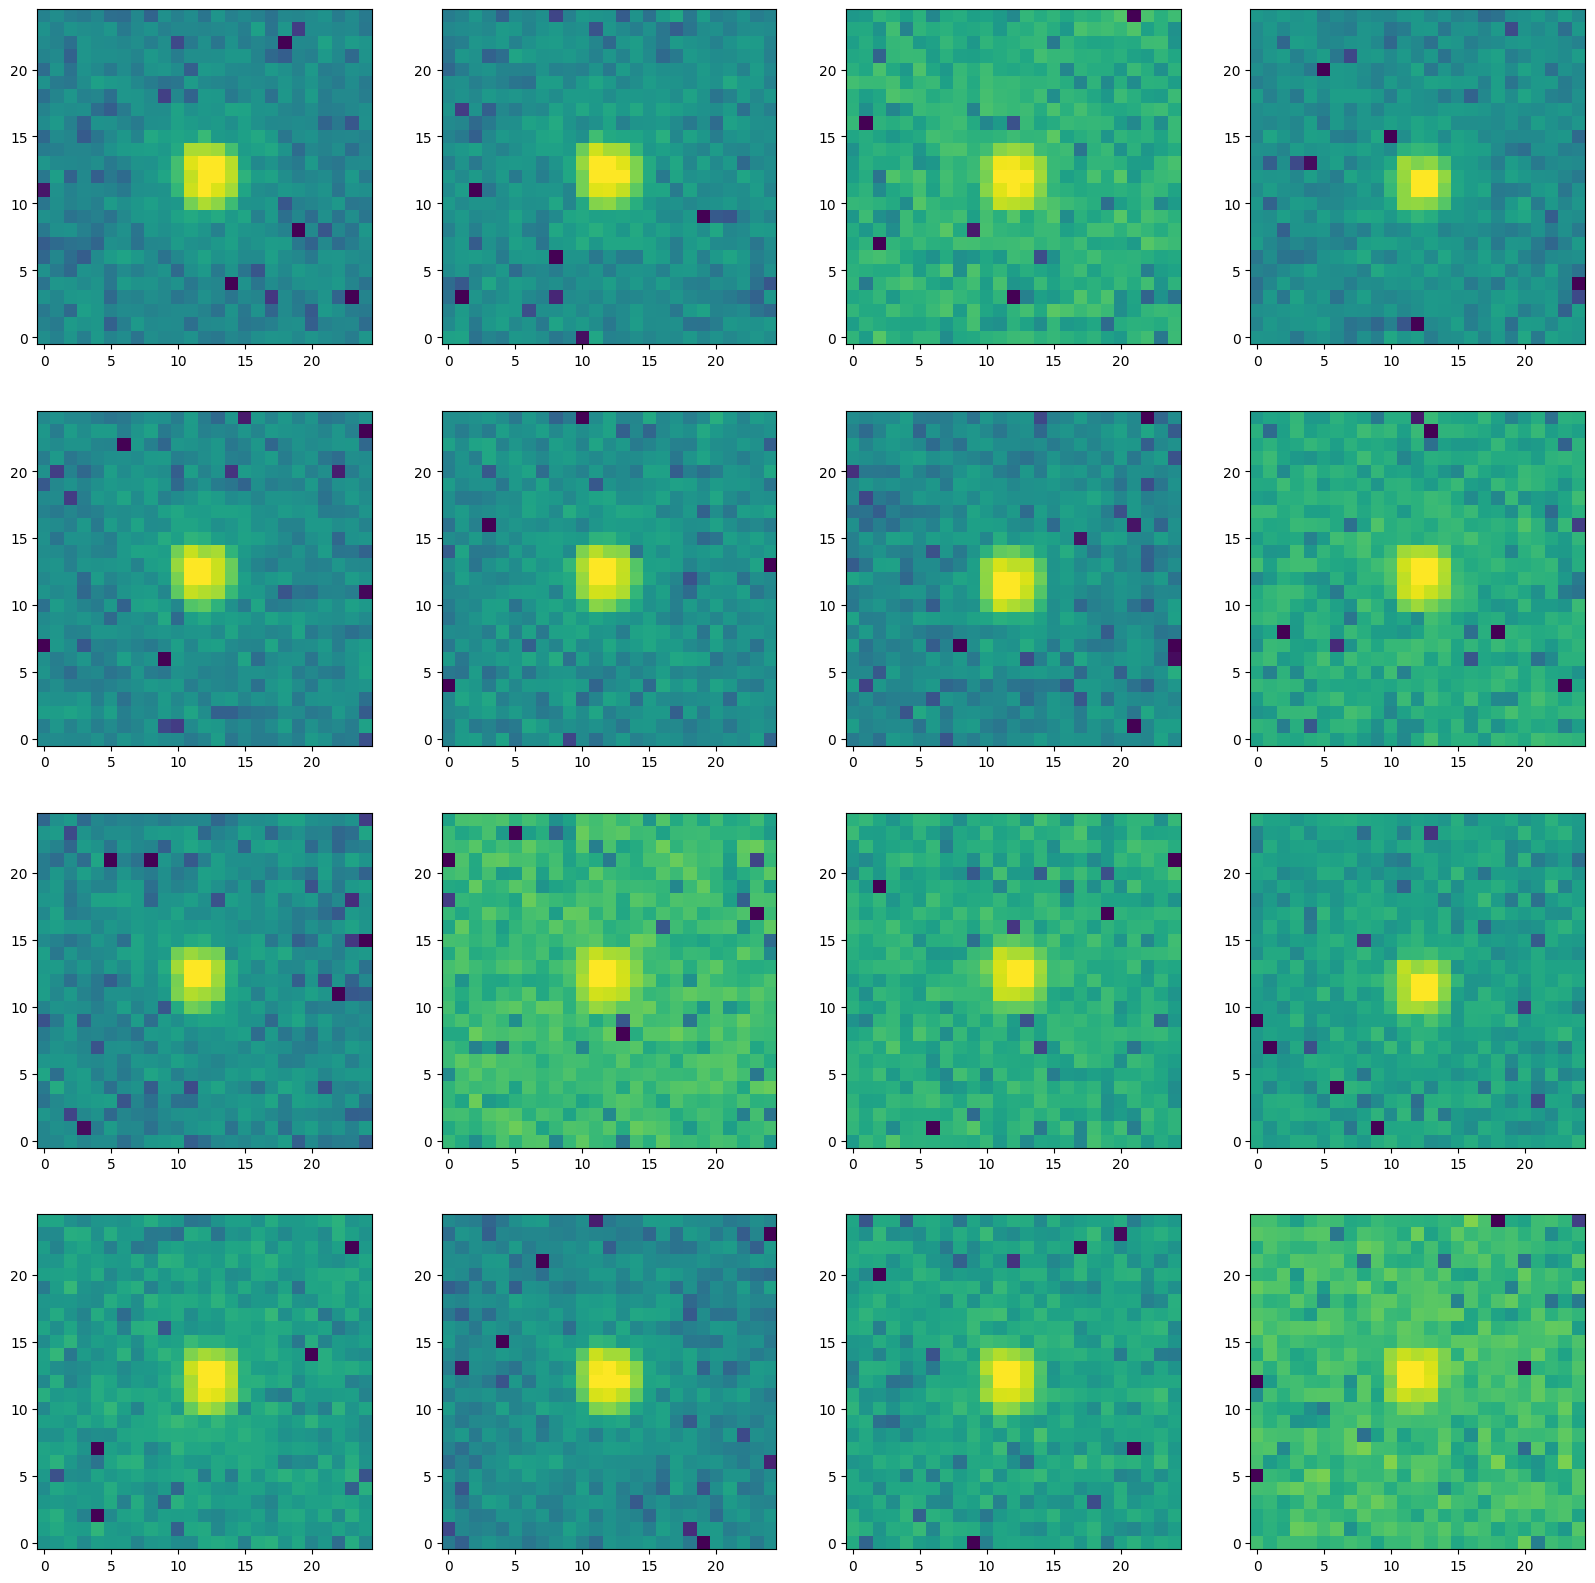

In [18]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
nrows = 4
ncols = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent=99.0)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')

In [19]:
from photutils.psf import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           progress_bar=True)

In [20]:
epsf, fitted_stars = epsf_builder(stars)

EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

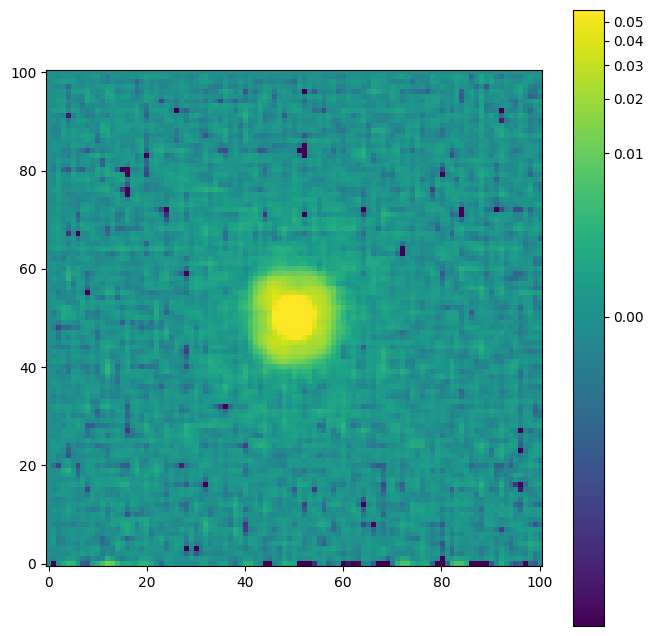

In [21]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
fig, ax = plt.subplots(figsize=(8, 8))
norm = simple_norm(epsf.data, 'log', percent=99.0)
axim = ax.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar(axim)

In [22]:
from photutils.psf import PSFPhotometry
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.table import Table
import numpy as np

fitter = LevMarLSQFitter()

psfphot = PSFPhotometry(
    psf_model=epsf,        # <-- tu ePSF
    fit_shape=(11, 11),    # debe cubrir bien la PSF
    finder=None,           # porque tú ya tienes las posiciones
    fitter=fitter,
    aperture_radius=5      # solo para estimación inicial de flux
)


In [23]:
from photutils.psf import PSFPhotometry
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.table import Table

fitter = LevMarLSQFitter()

psfphot = PSFPhotometry(
    psf_model=epsf,
    fit_shape=(11, 11),
    fitter=fitter,
    aperture_radius=5
)

init_params = Table()
init_params["x_0"] = sources["x"]
init_params["y_0"] = sources["y"]

result = psfphot(data, init_params=init_params)


In [24]:
result

id,group_id,group_size,local_bkg,x_init,y_init,flux_init,x_fit,y_fit,flux_fit,x_err,y_err,flux_err,npixfit,qfit,cfit,flags
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64
1,1,1,0.0,223.44700054160825,170.83926542950798,6238.16303953902,223.68968855826563,171.11581156035584,6091.639921236602,0.005214594004460777,0.009562195265539005,42.18809199177623,121,0.206776528072614,-0.0014499763092775118,0
2,2,1,0.0,215.89933234954475,211.4059848944316,6781.300661053444,215.88807765147988,211.58381573489802,6750.260172894945,0.007955311738117754,0.0038213036230293016,42.69901972673963,121,0.18880306785414966,-0.00033087154548062025,0
3,3,1,0.0,192.4760433144535,228.19787513581653,8279.073763231134,192.5677811520551,228.25411334141126,8413.316969545,0.0033748721372197856,0.004745755476498981,42.45999341991867,121,0.1460056775268169,-0.0002562094014868871,0
4,4,1,0.0,187.53527210248637,195.06270753419324,4351.644469761349,187.86706143524572,195.31166277881698,4123.853741557502,0.010478454166336238,0.007128769992632623,40.87498605602933,121,0.29325639736368236,-0.0024515386458312857,0
5,5,1,0.0,260.44473939746723,212.8301660350818,10885.384605037716,260.46646998575824,212.69274425349533,11074.577574253934,0.003481944946944299,0.004195163196635484,64.99535280396954,121,0.1709998811731596,-0.0003358260540366378,0
6,6,1,0.0,289.89469801299373,200.71318974450932,7679.261069997048,290.110177568112,201.71302959280777,7723.464065763577,0.005259845923781381,0.0036881164917237745,39.50623260653964,121,0.16160863559295252,-0.0011736692941896,0
7,7,1,0.0,282.47543038486106,257.1045407773552,9645.810686672312,282.78016084147833,257.3794318585606,10101.4464875331,0.0042756224299860665,0.0029993575715349993,46.25761376231038,121,0.13045653180409109,-0.002095236334622524,0
8,8,1,0.0,312.74905822091824,267.84144988021046,11479.72030676161,312.98841929515595,268.02101765423504,11748.994055567122,0.00451786711170767,0.004724569478073175,41.45402104753555,121,0.1216116096216404,-0.0017242218653867381,0
9,9,1,0.0,353.8584632451291,210.8197023074964,9546.241956290442,353.904192047795,211.20260215119447,9803.077396418372,0.005038145167951962,0.004392758068160542,44.96273444695904,121,0.13703422639544954,-0.0017079417272451304,0
